In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


In [4]:
import utils
import train
import torch.utils.data as utils
import torch.nn as nn

Importing all necessary modules...
...DONE
Checking if GPU is available...
...NO :(


In [5]:
#no gpu available
device = torch.device("cpu")

In [6]:
qcd_file = "Models/qcd_trained.h5"
zjets_file = "Models/zjets_trained.h5"

In [7]:
version = 0
zdim = 4
nflow = 2
lr = 5e-3
beta = 0.1 
nfeats=7

def load_model(filename):
    model = train.VAE_NF(nflow, zdim, nfeats).to(device)
    model.load_state_dict(torch.load(filename))
    return model

qcd_model = load_model(qcd_file)
zjets_model = load_model(zjets_file)
# qcd_model.eval()

In [8]:
def dataloader(f, feature):
    data = np.load(f)
    arr = data[feature]
    Y = np.array(arr.tolist())
    # print(Y.shape)

    # normalize
    bkg_mean = []
    bkg_std = []

    for i in range(Y.shape[1]):
        mean = np.mean(Y[:,i])
        std = np.std(Y[:,i])
        bkg_mean.append(mean)
        bkg_std.append(std)
        Y[:,i] = (Y[:,i]-mean)/std

    total_PureBkg = torch.tensor(Y)
    # print(total_PureBkg)

    bs = 1
    # bkgAE_train_iterator = utils.DataLoader(total_PureBkg, batch_size=bs, shuffle=True)
    bkgAE_test_iterator = utils.DataLoader(total_PureBkg, batch_size=bs)

    return bkgAE_test_iterator
    all_batches = []
    for batch in dataloader:
        inputs = batch  # If batch is a tuple of (inputs, targets)
        all_batches.append(inputs)
    all_data_tensor = torch.cat(all_batches, dim=0)  # Concatenate along the first dimension
    return all_data_tensor


In [9]:
def evaluate_for_loss(model, test_iterator, split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(test_iterator):

            x = x.float().to(device)

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            huberloss = nn.SmoothL1Loss(size_average=False)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            loss = loss_recons # + beta * kl_div

            val_loss.append(loss.item())

    print('\nEvaluation Completed ({})!\tMean Loss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss)

def evaluate_for_xtilda(model, test_iterator, split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(test_iterator):

            x = x.float().to(device)

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            huberloss = nn.SmoothL1Loss(size_average=False)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())

    return x_tilde


In [10]:
#train, test, mean
qcd_jet = dataloader('data_for_training/QCD_HT1500to2000_part000.npz', 'jet')
z_jet = dataloader('data_for_training/ZJetsToQQ_HT-800toInf_part000.npz', 'jet')
qtest_jet = dataloader('data_for_training/QCDpart001.npz', 'jet')
ztest_jet = dataloader('data_for_training/ZJetpart001.npz', 'jet')


# qcd_jet
qqcd_loss = evaluate_for_loss(qcd_model, qtest_jet)
qzjets_loss = evaluate_for_loss(zjets_model, qtest_jet)


zqcd_loss = evaluate_for_loss(qcd_model, ztest_jet)
zzjets_loss = evaluate_for_loss(zjets_model, ztest_jet)

/afs/cern.ch/work/f/fdaly/miniforge3/envs/quak/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Mean Loss: 1.4306 Time: 7.180 s

Evaluation Completed (valid)!	Mean Loss: 1.5098 Time: 5.878 s

Evaluation Completed (valid)!	Mean Loss: 1.5012 Time: 3.256 s

Evaluation Completed (valid)!	Mean Loss: 1.4655 Time: 3.215 s


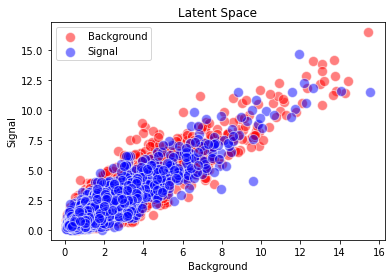

In [11]:
plt.scatter(qqcd_loss, qzjets_loss, c='red', marker='o', s=100, alpha=0.5, edgecolors='w', label='Background')
plt.scatter(zqcd_loss, zzjets_loss, c='blue', marker='o', s=100, alpha=0.5, edgecolors='w', label='Signal')

# Add title and labels
plt.title('Latent Space')
plt.xlabel('Background')
plt.ylabel('Signal')

# Add a legend (optional)
plt.legend()

plt.savefig('Plots/Latent_Space.png', format='png')
# Display the plot
plt.show()
